# Arrhythmia detection

## ECG signal 
<img src="ecg.png" alt="ECG" width="700" height="452">

## Data preprocessing

### Packages

In [19]:
import logging
import os
import pickle
import time
from collections import Counter

import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
import wfdb
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from util import map_peak_annotations

### Constants

In [16]:
# From the BIH database docs
db_file = 'mit-bih-arrhythmia-database-1.0.0'
records_filename = 'records_dwt.pkl'
dataframe_filename = 'dataframe_dwt.pkl'
grid_search_filename = 'grid_search.pkl'
beat_annotations = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f']
sampling_rate = 360

### Load records, detect peaks, onsets, offsets and map annotations to R peaks

In [3]:
# Try to load records from the local pickle file
records = []
try:
    with open(records_filename, 'rb') as file:
        records = pickle.load(file)
except FileNotFoundError:
    # Load the database
    if not os.path.isdir(db_file):
        logging.error('Please replace dbdir with the db file path')
        raise FileNotFoundError(db_file)

    # Fill records
    avg_time_elapsed = 0
    iteration_time_slices = []
    print("Start filling records")
    for i in range(100, 220):
        start_time = time.time()
        try:
            bih_record = wfdb.rdrecord('{}/{}'.format(db_file, i))
            annotation = wfdb.rdann('{}/{}'.format(db_file, i), 'atr')
        except FileNotFoundError:
            continue

        # Extract age and gender
        record_info = bih_record.comments[0]
        age = int(record_info[0:2])
        gender = 0 if ' M ' in record_info else (1 if ' F ' in record_info else np.nan)

        # Create a list of tuples of beat symbols and the sample at which it is annotated
        dtype = [('sample', 'i4'), ('symbol', 'U1')]
        allowed_beat_mask = np.isin(annotation.symbol, beat_annotations)
        annotations = np.array([(int(i), s) for i, s in zip(annotation.sample[allowed_beat_mask],
                                                            np.array(annotation.symbol)[allowed_beat_mask])],
                               dtype=dtype)

        # Read the signal from the bih_record
        ecg_signal = bih_record.p_signal[:, 0]

        # Find all r peaks in a record
        _, r_peaks = nk.ecg_peaks(ecg_signal, sampling_rate)

        # Map beat annotations to R-peaks
        annotated_r_peaks = map_peak_annotations(r_peaks['ECG_R_Peaks'], annotations)

        # Find other peaks, onsets and offsets
        _, waves_peaks = nk.ecg_delineate(ecg_signal, r_peaks, sampling_rate, method="dwt")

        # Save the attributes to a record
        records.append({'ecg_signal': ecg_signal,
                        'annotated_r_peaks': annotated_r_peaks,
                        'waves_peaks': waves_peaks,
                        'r_peaks': r_peaks,
                        'age': age,
                        'gender': gender})
        
        # Show remaining time
        end_time = time.time()
        time_elapsed = end_time - start_time
        iteration_time_slices.append(time_elapsed)
        remaining_files_count = (37 - (i % 100)) if i < 200 else (37 - (i % 200))
        np.mean(iteration_time_slices)
        print(
            f"Record {i} appended, time elapsed: {int(np.sum(iteration_time_slices) / 60)}:{int(np.sum(iteration_time_slices) % 60)}min\n"
            f"Approx. remaining time: {int(remaining_files_count * np.mean(iteration_time_slices) / 60)}:{int(remaining_files_count * np.mean(iteration_time_slices) % 60)}min\n"
            f"------------------------------------------")

    # Due to somewhat long execution time of the wavelet transform we save the result to a file for future use
    print("Saving records to file")
    with open(records_filename, 'wb') as file:
        pickle.dump(records, file)

### Few records have unknown age, so we set it to average

In [4]:
age = np.ndarray(0)

# Remove records with unknown age from mean the calculation
for record in records:
    if record['age'] != -1:
        age = np.append(age, record['age'])

# Calculate mean
age_mean = int(np.mean(age))

# Set unknown age attributes to mean value
for record in records:
    if record['age'] == -1:
        record['age'] = age_mean

## Feature extraction
<img src="ecg_features.png" alt="Features" width="700" height="420">

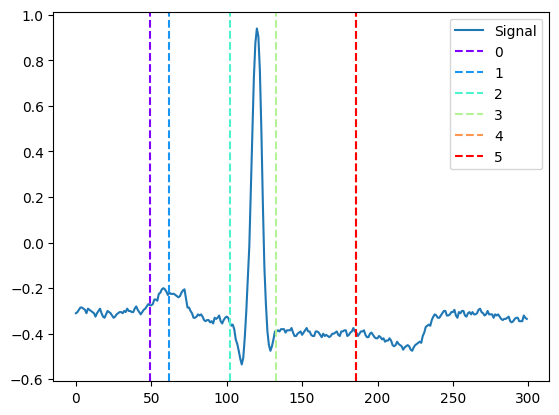

In [5]:
plot = nk.events_plot([np.array(records[0]['waves_peaks']['ECG_P_Onsets'][:1]) - 250,
                       np.array(records[0]['waves_peaks']['ECG_P_Offsets'][:1]) - 250,
                       np.array(records[0]['waves_peaks']['ECG_R_Onsets'][:1]) - 250,
                       np.array(records[0]['waves_peaks']['ECG_R_Offsets'][:1]) - 250,
                       np.array(records[0]['waves_peaks']['ECG_T_Offsets'][:1]) - 250,
                       np.array(records[0]['waves_peaks']['ECG_T_Offsets'][:1]) - 250],
                      records[0]['ecg_signal'][250:550])

### We can see from the neurokit2 documentation visualization the following:
   * the R onset (neurokit2) represents the Q onset
   * the R offset (neurokit2) represents S offset

### Features to extract
* P duration
* PR segment
* PR interval
* Q duration
* R duration
* S duration
* QRS duration
* ST segment
* ST interval
* age
* gender

In [6]:
# Initialize ndarrays for features
label = np.ndarray(0)
p_duration = np.ndarray(0)
pr_segment = np.ndarray(0)
pr_interval = np.ndarray(0)
qrs_duration = np.ndarray(0)
st_segment = np.ndarray(0)
st_interval = np.ndarray(0)
age = np.array(0)
gender = np.array(0)

# Loop through records and calculate features
for record in records:
    # Save wave values to variables for readability
    p_onsets = np.array(record['waves_peaks']['ECG_P_Onsets'])
    p_offsets = np.array(record['waves_peaks']['ECG_P_Offsets'])
    r_onsets = np.array(record['waves_peaks']['ECG_R_Onsets'])
    r_offsets = np.array(record['waves_peaks']['ECG_R_Offsets'])
    t_onsets = np.array(record['waves_peaks']['ECG_T_Onsets'])
    t_offsets = np.array(record['waves_peaks']['ECG_T_Offsets'])
    r_peaks = np.array(record['r_peaks']['ECG_R_Peaks'])

    # Extract labels
    record_labels = record['annotated_r_peaks'][:, 1]
    label = np.append(label, record_labels)
    # Set age
    age = np.append(age, np.full(len(record_labels), record['age']))
    # Set gender
    gender = np.append(gender, np.full(len(record_labels), record['gender']))
    # Extract P duration (P offset - P onset)
    p_duration = np.append(p_duration, (p_offsets - p_onsets) / sampling_rate)
    # Extract PR segment (R onset - P offset)
    pr_segment = np.append(pr_segment, (r_onsets - p_offsets) / sampling_rate)
    # Extract PR interval (R onset - P onset)
    pr_interval = np.append(pr_interval, (r_onsets - p_onsets) / sampling_rate)
    # Extract QRS duration (R offset - R onset)
    qrs_duration = np.append(qrs_duration, (r_offsets - r_onsets) / sampling_rate)
    # Extract ST segment (T onset - R offset)
    st_segment = np.append(st_segment, (t_onsets - r_offsets) / sampling_rate)
    # Extract ST interval (T offset - R offset)
    st_interval = np.append(st_interval, (t_offsets - r_offsets) / sampling_rate)

# Somewhere an extra 0 element appears so we remove it
age = age[1:]
gender = gender[1:]

### Create a dataframe from records

In [7]:
dataframe = pd.DataFrame(
    {
        'age': age,
        'gender': gender,
        'p_duration': p_duration,
        'pr_segment': pr_segment,
        'pr_interval': pr_interval,
        'qrs_duration': qrs_duration,
        'st_segment': st_segment,
        'st_interval': st_interval,
        'label': label
    }
)

### Clean the dataframe 

In [8]:
# Clean rows with NaN values
dataframe = dataframe.dropna()

with open(dataframe_filename, 'wb') as file:
    pickle.dump(dataframe, file)

### Distribution of beat types

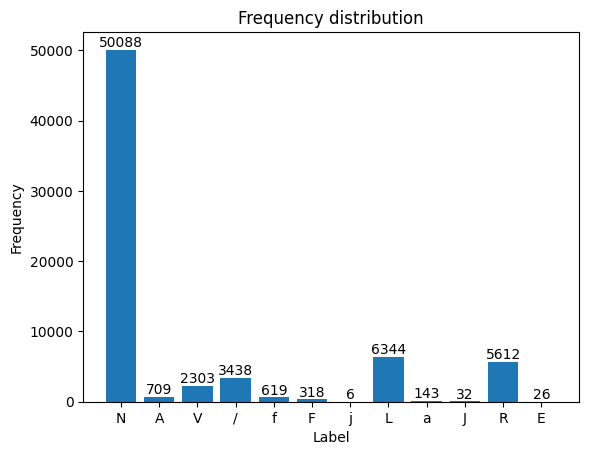

In [9]:
labels, frequency = zip(*Counter([s[0] for s in dataframe['label']]).items())
plt.bar(labels, frequency)
for i, v in enumerate(frequency):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.title('Frequency distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

## Machine learning

### Scale features and split the dataset into training and testing sets 

In [10]:
# Separate the label column from the feature columns
X = dataframe.drop('label', axis=1)
y = dataframe['label']

dataframe = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Train the SVM model (with Gaussian radial basis kernel) using Grid Search

In [11]:
# C=100 and gamma=1 are best parameters after grid search
param_grid = {
    'C': [100],  # Regularization parameter
    'gamma': [1],  # Kernel coefficient
    'kernel': ['rbf']
}

# GridSearchCV object cross-validates the training set and finds the best hyperparameters
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=2)

grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END ........C=100, gamma=1, kernel=rbf;, score=0.952 total time=  13.8s
[CV 2/2] END ........C=100, gamma=1, kernel=rbf;, score=0.948 total time=  14.3s
Best Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}


### Save the model to file

In [12]:
with open(grid_search_filename, 'wb') as file:
    pickle.dump(grid_search, file)

### Predict the test data points and evaluate the model

In [17]:
with open(grid_search_filename, 'rb') as file:
    grid_search = pickle.load(file)

y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

### Plot heatmap of classification report

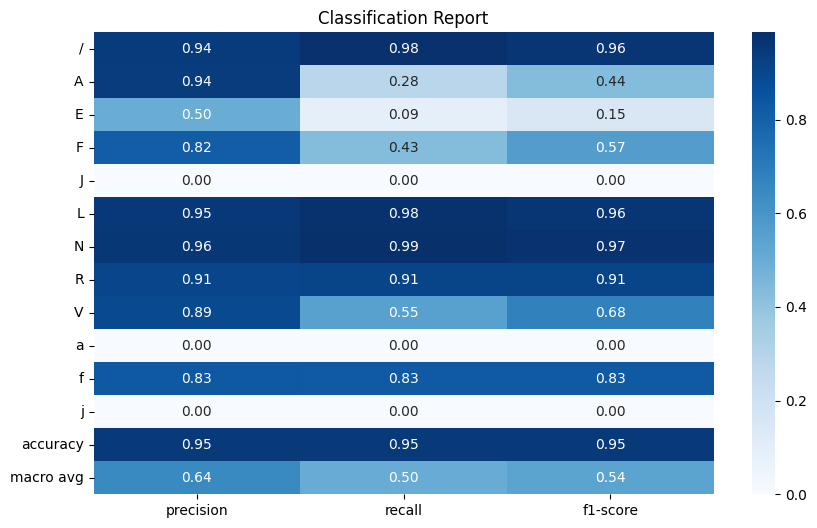

Accuracy: 0.95

Classification Report:
{'/': {'precision': 0.9419475655430711, 'recall': 0.9805068226120858, 'f1-score': 0.9608404966571155, 'support': 1026.0}, 'A': {'precision': 0.9393939393939394, 'recall': 0.2831050228310502, 'f1-score': 0.4350877192982456, 'support': 219.0}, 'E': {'precision': 0.5, 'recall': 0.09090909090909091, 'f1-score': 0.15384615384615385, 'support': 11.0}, 'F': {'precision': 0.8163265306122449, 'recall': 0.43478260869565216, 'f1-score': 0.5673758865248227, 'support': 92.0}, 'J': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11.0}, 'L': {'precision': 0.9521580863234529, 'recall': 0.9780982905982906, 'f1-score': 0.9649538866930171, 'support': 1872.0}, 'N': {'precision': 0.9578797304302747, 'recall': 0.9862556712036296, 'f1-score': 0.9718606180144642, 'support': 14988.0}, 'R': {'precision': 0.9089848308051341, 'recall': 0.9095154699357851, 'f1-score': 0.9092500729501021, 'support': 1713.0}, 'V': {'precision': 0.8924485125858124, 'recall': 0.5500

In [20]:
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report")
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

### Plot heatmap of confusion matrix

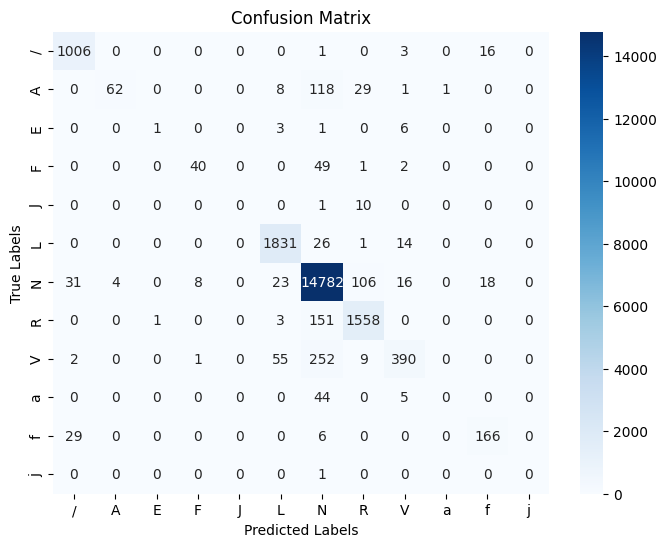


Confusion Matrix:
[[ 1006     0     0     0     0     0     1     0     3     0    16     0]
 [    0    62     0     0     0     8   118    29     1     1     0     0]
 [    0     0     1     0     0     3     1     0     6     0     0     0]
 [    0     0     0    40     0     0    49     1     2     0     0     0]
 [    0     0     0     0     0     0     1    10     0     0     0     0]
 [    0     0     0     0     0  1831    26     1    14     0     0     0]
 [   31     4     0     8     0    23 14782   106    16     0    18     0]
 [    0     0     1     0     0     3   151  1558     0     0     0     0]
 [    2     0     0     1     0    55   252     9   390     0     0     0]
 [    0     0     0     0     0     0    44     0     5     0     0     0]
 [   29     0     0     0     0     0     6     0     0     0   166     0]
 [    0     0     0     0     0     0     1     0     0     0     0     0]]


In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nConfusion Matrix:")
print(conf_matrix)